In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.model_selection import KFold,GridSearchCV,train_test_split,RandomizedSearchCV
from sklearn.linear_model import LinearRegression,LogisticRegression,Ridge,Lasso
from sklearn.svm import SVC
from sklearn import tree
import graphviz,pydotplus
from IPython.display import Image,display
from sklearn.metrics import f1_score,accuracy_score,mean_absolute_error, mean_squared_error,r2_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.pipeline import make_pipeline

## 0. Data processing and visualization
load winequality-white.csv dataset and make exploratory data analysis

In [2]:
wine = pd.read_csv('winequality-white.csv',sep=';')
print(wine.shape)
wine.head()

(4898, 12)


fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.0              0.27         0.36            20.7      0.045   
1            6.3              0.30         0.34             1.6      0.049   
2            8.1              0.28         0.40             6.9      0.050   
3            7.2              0.23         0.32             8.5      0.058   
4            7.2              0.23         0.32             8.5      0.058   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 45.0                 170.0   1.0010  3.00       0.45   
1                 14.0                 132.0   0.9940  3.30       0.49   
2                 30.0                  97.0   0.9951  3.26       0.44   
3                 47.0                 186.0   0.9956  3.19       0.40   
4                 47.0                 186.0   0.9956  3.19       0.40   

   alcohol  quality  
0      8.8        6  
1      9.5        6  
2     10.1        6  
3      9.9        6  
4      9.9        6

In [3]:
print(wine.isnull().sum())
print('\nDuplicated rows',wine.duplicated().sum())

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

Duplicated rows 937


In [4]:
wine1 = wine.drop(wine[wine.duplicated()==True].index,axis=0)
wine1 = wine1.reindex(index = list(range(0,wine1.shape[0])),method='bfill')
wine1.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.0              0.27         0.36            20.7      0.045   
1            6.3              0.30         0.34             1.6      0.049   
2            8.1              0.28         0.40             6.9      0.050   
3            7.2              0.23         0.32             8.5      0.058   
4            6.2              0.32         0.16             7.0      0.045   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 45.0                 170.0   1.0010  3.00       0.45   
1                 14.0                 132.0   0.9940  3.30       0.49   
2                 30.0                  97.0   0.9951  3.26       0.44   
3                 47.0                 186.0   0.9956  3.19       0.40   
4                 30.0                 136.0   0.9949  3.18       0.47   

   alcohol  quality  
0      8.8        6  
1      9.5        6  
2     10.1        6  
3      9.9        6  
4      9.6        6

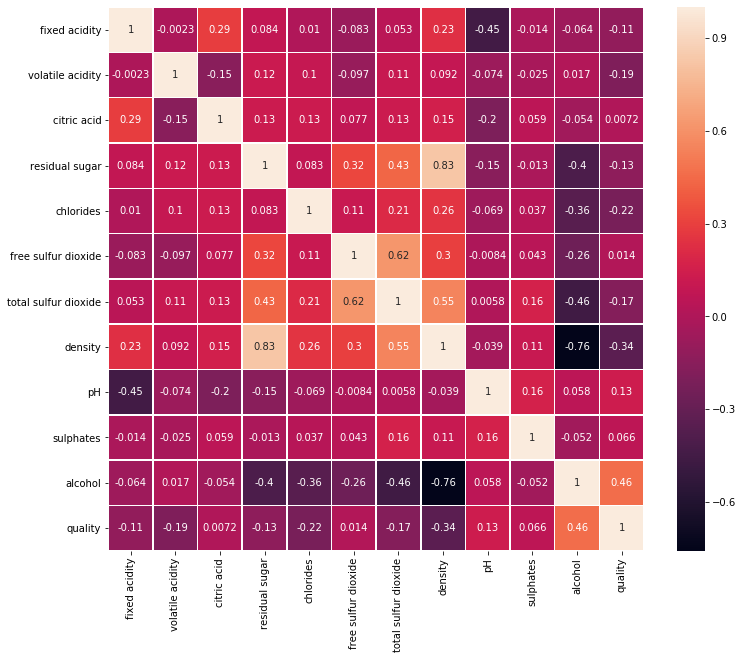

In [5]:
fig = plt.figure(figsize=(12,10))
ax = sns.heatmap(wine1.corr(),annot=True,linewidths=0.5)
ax.set_ylim(np.array(ax.get_ylim())+np.array((0.5,-0.5)))
plt.show()

In [6]:
wine1.describe()

fixed acidity  volatile acidity  citric acid  residual sugar  \
count    3961.000000       3961.000000  3961.000000     3961.000000   
mean        6.933136          0.276536     0.340235        5.931318   
std         0.863569          0.103027     0.124073        4.912450   
min         4.200000          0.080000     0.000000        0.600000   
25%         6.400000          0.210000     0.270000        1.600000   
50%         6.800000          0.260000     0.320000        4.750000   
75%         7.400000          0.320000     0.400000        8.800000   
max        14.200000          1.005000     1.660000       65.800000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  3961.000000          3961.000000           3961.000000  3961.000000   
mean      0.045796            35.106413            138.891568     0.993964   
std       0.023559            17.187784             43.793898     0.002913   
min       0.009000             2.000000              9.000000     0.987130   
25%       0.035000            23.000000            107.000000     0.991800   
50%       0.042000            33.000000            135.000000     0.993700   
75%       0.050000            46.000000            168.000000     0.995840   
max       0.346000           146.500000            366.500000     1.038980   

                pH    sulphates      alcohol      quality  
count  3961.000000  3961.000000  3961.000000  3961.000000  
mean      3.198066     0.486541    10.520399     5.841959  
std       0.151847     0.112435     1.206961     0.913018  
min       2.720000     0.220000     8.000000     3.000000  
25%       3.100000     0.410000     9.500000     5.000000  
50%       3.190000     0.470000    10.400000     6.000000  
75%       3.290000     0.540000    11.400000     6.000000  
max       3.820000     1.060000    14.200000     9.000000

In [7]:
#sns.pairplot(wine1,hue='quality')

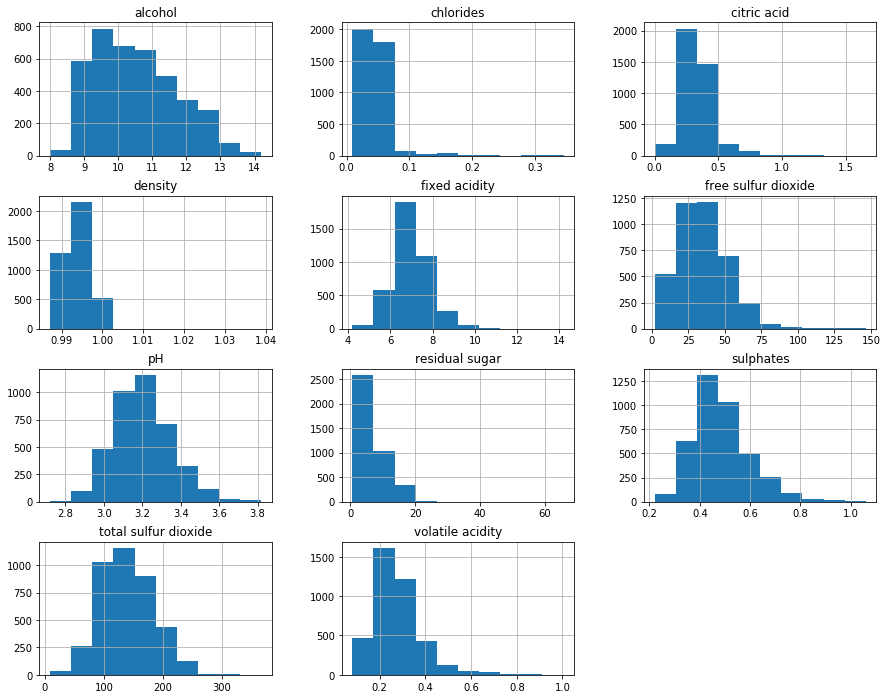

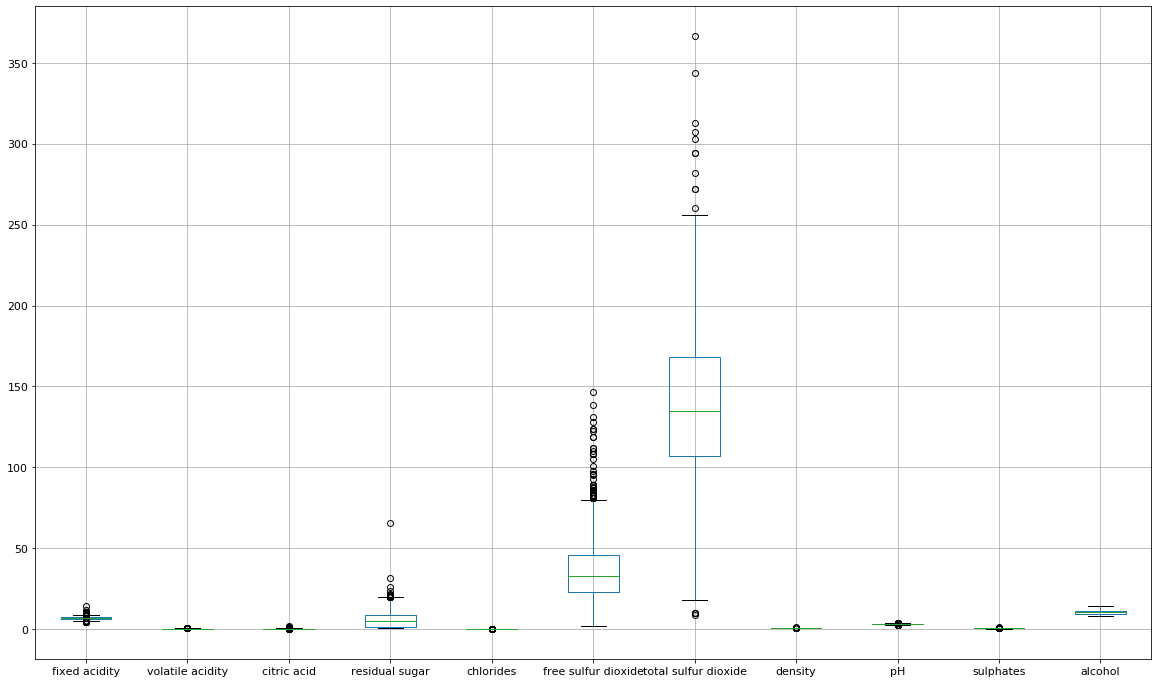

In [8]:
wine1[wine1.columns[:-1]].hist(figsize=(15,12))
plt.show()

boxplot = wine1.boxplot(column=list(wine1.columns[:-1]),figsize=(20,12),fontsize=11)

## 1. Decision trees classification
In this task we will try to predict wine quality based on its features by fitting a decision tree model. Fit a decision tree classifier by making a grid search over loss functions: 'giny', 'entropy' and over max_leaf_nodes parameter. Choose this parameters via 5-Fold cross-validation. Visualize the best model's tree diagram

In [9]:
cv = KFold(5,shuffle=True)

target = wine1['quality']
data = wine1[wine1.columns[:-1]]
data.head()

xtrain,xtest,ytrain,ytest = train_test_split(data,target,random_state=25,test_size=0.2)

st = StandardScaler()
X = st.fit_transform(xtrain)
x = st.transform(xtest)

param_grid = {'criterion':["gini",'entropy'],'max_leaf_nodes':[None]+list(range(2,100))}

grid = GridSearchCV(DecisionTreeClassifier(),param_grid,refit=True,verbose=1,cv=cv)
grid.fit(X,ytrain)


Fitting 5 folds for each of 198 candidates, totalling 990 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 990 out of 990 | elapsed:   21.2s finished


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
             error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             par

In [10]:
print("The best DecisionTreeClassifier test score is %s corresponding to hyperparameters %s" %(grid.best_score_,grid.best_params_))

The best DecisionTreeClassifier test score is 0.5729160125784283 corresponding to hyperparameters {'criterion': 'gini', 'max_leaf_nodes': None}


In [11]:
Cart = DecisionTreeClassifier(criterion = grid.best_params_['criterion'],max_leaf_nodes =grid.best_params_['max_leaf_nodes'])
Cart.fit(X,ytrain)
pred_tree = Cart.predict(x)
print('Accuracy score for DecisionTreeClassifier',accuracy_score(pred_tree,ytest))

Accuracy score for DecisionTreeClassifier 0.5813366960907944


In [12]:
dot_data = tree.export_graphviz(Cart,feature_names = list(data.columns),
                                class_names = [str(i) for i in target.unique()],
                                filled =True,special_characters=True)

graph = pydotplus.graph_from_dot_data(dot_data)

colors = ['blue','green','brown','cyan','magenta','yellow','red']
nodes = graph.get_node_list()

for node in nodes:
    if node.get_label():
        values = [int(i) for i in node.get_label()[node.get_label().index('[')+1:node.get_label().index(']')].split(', ')]
        node.set_fillcolor(colors[np.argmax(values)])
        

Image(graph.create_png())

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.51895 to fit



## 2. Comparison classification
Try to predict wine quality with other classification tools that we studied(Logistic Regression, SVM, LDA) compare the accuracies and f-scores of all models on the test set and choose the best performing algorithm. 

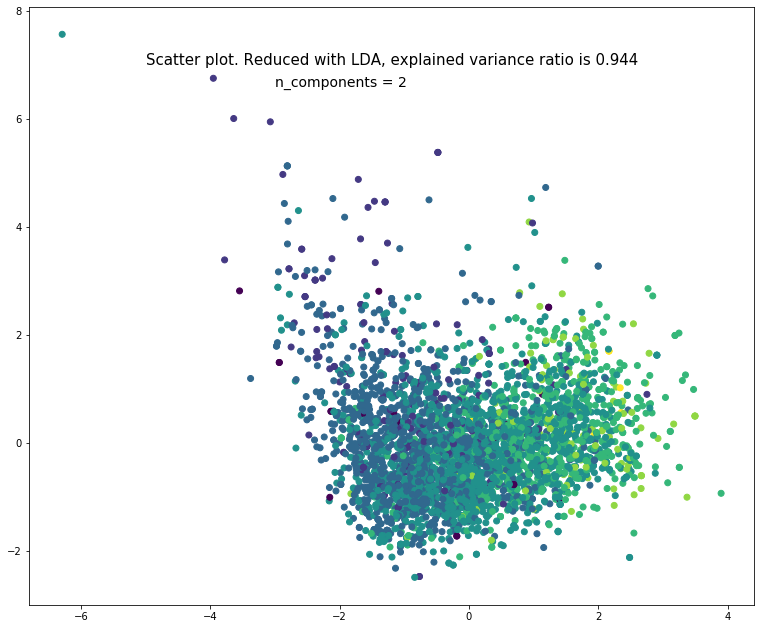

In [13]:
fig = plt.figure(figsize=(13,11))
lda = LDA(n_components=2)
lda1 = lda.fit_transform(data,target)
plt.scatter(lda1[:,0],lda1[:,1], c = target)
var = round(sum(lda.explained_variance_ratio_),3)
plt.text(-5,7,'Scatter plot. Reduced with LDA, explained variance ratio is '+str(var),fontsize=15)
plt.text(-3,6.6,'n_components = 2',fontsize=14)
plt.show()

In [14]:
xtrain,xtest,ytrain,ytest = train_test_split(lda1,target,random_state=25,test_size=0.2)


In [15]:
param_grid = {'C': [0.1,1, 10, 100,1000], 'gamma': [1,0.1,0.01,0.001,0.0001], 'kernel': ['rbf','sigmoid']}

grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=1,cv=cv)
grid.fit(xtrain,ytrain)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  6.3min finished


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
             error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf', 'sigmoid']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=1)

In [16]:
print("The best SVC test score is %s corresponding to hyperparameters %s" %(grid.best_score_,grid.best_params_))

The best SVC test score is 0.5362870712295862 corresponding to hyperparameters {'C': 10, 'gamma': 1, 'kernel': 'rbf'}


In [17]:
svc = SVC(C = grid.best_params_['C'],kernel = grid.best_params_['kernel'],gamma = grid.best_params_['gamma'])
svc.fit(xtrain,ytrain)
pred_svc = svc.predict(xtest)
print('Accuracy score for SVC',accuracy_score(pred_svc,ytest))

Accuracy score for SVC 0.5145018915510718


In [18]:
param_grid = {'C': [0.01,0.1,1, 10, 100, 1000],'max_iter':[10000] ,
                  'multi_class':['ovr','multinomial'],'l1_ratio':[0,0.25,0.5,0.75,1]}
grid  = RandomizedSearchCV(LogisticRegression(penalty='elasticnet',solver='saga'),param_grid,verbose=2,refit=True,cv=cv)
grid.fit(xtrain,ytrain)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] multi_class=ovr, max_iter=10000, l1_ratio=0.25, C=0.1 ...........
[CV]  multi_class=ovr, max_iter=10000, l1_ratio=0.25, C=0.1, total=   0.1s
[CV] multi_class=ovr, max_iter=10000, l1_ratio=0.25, C=0.1 ...........


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV]  multi_class=ovr, max_iter=10000, l1_ratio=0.25, C=0.1, total=   0.2s
[CV] multi_class=ovr, max_iter=10000, l1_ratio=0.25, C=0.1 ...........
[CV]  multi_class=ovr, max_iter=10000, l1_ratio=0.25, C=0.1, total=   0.1s
[CV] multi_class=ovr, max_iter=10000, l1_ratio=0.25, C=0.1 ...........
[CV]  multi_class=ovr, max_iter=10000, l1_ratio=0.25, C=0.1, total=   0.1s
[CV] multi_class=ovr, max_iter=10000, l1_ratio=0.25, C=0.1 ...........
[CV]  multi_class=ovr, max_iter=10000, l1_ratio=0.25, C=0.1, total=   0.1s
[CV] multi_class=multinomial, max_iter=10000, l1_ratio=0.5, C=1 ......
[CV]  multi_class=multinomial, max_iter=10000, l1_ratio=0.5, C=1, total=   0.4s
[CV] multi_class=multinomial, max_iter=10000, l1_ratio=0.5, C=1 ......
[CV]  multi_class=multinomial, max_iter=10000, l1_ratio=0.5, C=1, total=   0.6s
[CV] multi_class=multinomial, max_iter=10000, l1_ratio=0.5, C=1 ......
[CV]  multi_class=multinomial, max_iter=10000, l1_ratio=0.5, C=1, total=   0.3s
[CV] multi_class=multinomial, max_

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   12.4s finished


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
                   error_score=nan,
                   estimator=LogisticRegression(C=1.0, class_weight=None,
                                                dual=False, fit_intercept=True,
                                                intercept_scaling=1,
                                                l1_ratio=None, max_iter=100,
                                                multi_class='auto', n_jobs=None,
                                                penalty='elasticnet',
                                                random_state=None,
                                                solver='saga', tol=0.0001,
                                                verbose=0, warm_start=False),
                   iid='deprecated', n_iter=10, n_jobs=None,
                   param_distributions={'C': [0.01, 0.1, 1, 10, 100, 1000],
                                        'l1_ratio': [0, 0.25, 0.5, 0.75, 1],
     

In [19]:
print("The best LogisticRegression test score is %s corresponding to hyperparameters %s" %(grid.best_score_,grid.best_params_))

The best LogisticRegression test score is 0.5356576514619183 corresponding to hyperparameters {'multi_class': 'ovr', 'max_iter': 10000, 'l1_ratio': 0, 'C': 100}


In [20]:
LOG = LogisticRegression(penalty='elasticnet',solver='saga',C = grid.best_params_['C'],
                        multi_class = grid.best_params_['multi_class'],
                        max_iter = grid.best_params_['max_iter'],l1_ratio = grid.best_params_['l1_ratio'])
LOG.fit(xtrain,ytrain)
pred_log = LOG.predict(xtest)
print('Accuracy score for logisticRegresiion',accuracy_score(pred_log,ytest))

Accuracy score for logisticRegresiion 0.5145018915510718


In [21]:
print('Accuracy score for DecisionTreeClassifier is ',accuracy_score(pred_tree,ytest))
print('F1 score score for DecisionTreeClassifier is ',f1_score(pred_tree,ytest,average = 'weighted'))

print('\nAccuracy score for SVC is ',accuracy_score(pred_svc,ytest))
print('F1 score score for SVC is ',f1_score(pred_svc,ytest,average = 'weighted'))


print('\nAccuracy score for LogisticRegresiion is ',accuracy_score(pred_log,ytest))
print('F1 score for LogisticRegresiion is ',f1_score(pred_log,ytest,average = 'weighted'))

Accuracy score for DecisionTreeClassifier is  0.5813366960907944
F1 score score for DecisionTreeClassifier is  0.5843780523530308

Accuracy score for SVC is  0.5145018915510718
F1 score score for SVC is  0.53891347791357

Accuracy score for LogisticRegresiion is  0.5145018915510718
F1 score for LogisticRegresiion is  0.5442210101870267


## 3. Decision trees regression
In this task we will use all the columns to predict alcohol concentration of a wine. Use the directives in task 1 as a guide to fit a Decision tree regressor.

In [96]:
target = wine1['alcohol']
data = wine1[wine1.columns.difference(['alcohol'])]

xtrain,xtest,ytrain,ytest = train_test_split(data,target,random_state=25,test_size=0.2)

st = StandardScaler()
X = st.fit_transform(xtrain)
x = st.transform(xtest)

param_grid = {'criterion':['mse','mae','friedman_mse'],'max_leaf_nodes':[None]+list(range(20,100))}

grid = RandomizedSearchCV(DecisionTreeRegressor(),param_grid,refit=True,cv=cv,verbose=3)
grid.fit(X,ytrain)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] max_leaf_nodes=74, criterion=friedman_mse .......................
[CV]  max_leaf_nodes=74, criterion=friedman_mse, score=0.818, total=   0.0s
[CV] max_leaf_nodes=74, criterion=friedman_mse .......................
[CV]  max_leaf_nodes=74, criterion=friedman_mse, score=0.809, total=   0.0s
[CV] max_leaf_nodes=74, criterion=friedman_mse .......................
[CV]  max_leaf_nodes=74, criterion=friedman_mse, score=0.815, total=   0.0s
[CV] max_leaf_nodes=74, criterion=friedman_mse .......................
[CV]  max_leaf_nodes=74, criterion=friedman_mse, score=0.811, total=   0.0s
[CV] max_leaf_nodes=74, criterion=friedman_mse .......................
[CV]  max_leaf_nodes=74, criterion=friedman_mse, score=0.834, total=   0.0s
[CV] max_leaf_nodes=23, criterion=mse ................................
[CV] .... max_leaf_nodes=23, criterion=mse, score=0.788, total=   0.0s
[CV] max_leaf_nodes=23, criterion=mse ........................

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



[CV] max_leaf_nodes=48, criterion=mse ................................
[CV] .... max_leaf_nodes=48, criterion=mse, score=0.808, total=   0.0s
[CV] max_leaf_nodes=48, criterion=mse ................................
[CV] .... max_leaf_nodes=48, criterion=mse, score=0.798, total=   0.0s
[CV] max_leaf_nodes=48, criterion=mse ................................
[CV] .... max_leaf_nodes=48, criterion=mse, score=0.817, total=   0.0s
[CV] max_leaf_nodes=27, criterion=friedman_mse .......................
[CV]  max_leaf_nodes=27, criterion=friedman_mse, score=0.785, total=   0.0s
[CV] max_leaf_nodes=27, criterion=friedman_mse .......................
[CV]  max_leaf_nodes=27, criterion=friedman_mse, score=0.792, total=   0.0s
[CV] max_leaf_nodes=27, criterion=friedman_mse .......................
[CV]  max_leaf_nodes=27, criterion=friedman_mse, score=0.776, total=   0.0s
[CV] max_leaf_nodes=27, criterion=friedman_mse .......................
[CV]  max_leaf_nodes=27, criterion=friedman_mse, score=0.774,

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    8.2s finished


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
                   error_score=nan,
                   estimator=DecisionTreeRegressor(ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features=None,
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   presort='deprecated',
                                                   random_state=None,
                          

In [32]:
print("The best DecisionTreeRegressor test score is %s corresponding to hyperparameters %s" %(grid.best_score_,grid.best_params_))

The best DecisionTreeRegressor test score is 0.8263258792506545 corresponding to hyperparameters {'max_leaf_nodes': 81, 'criterion': 'mse'}


In [34]:
Cart = DecisionTreeRegressor(criterion = grid.best_params_['criterion'],max_leaf_nodes =grid.best_params_['max_leaf_nodes'])
Cart.fit(X,ytrain)
pred_tree = Cart.predict(x)
print('R2_score for DecisionTreeRegressor is ',r2_score(ytest,pred_tree).round(3))

R2_score for DecisionTreeRegressor is  0.824


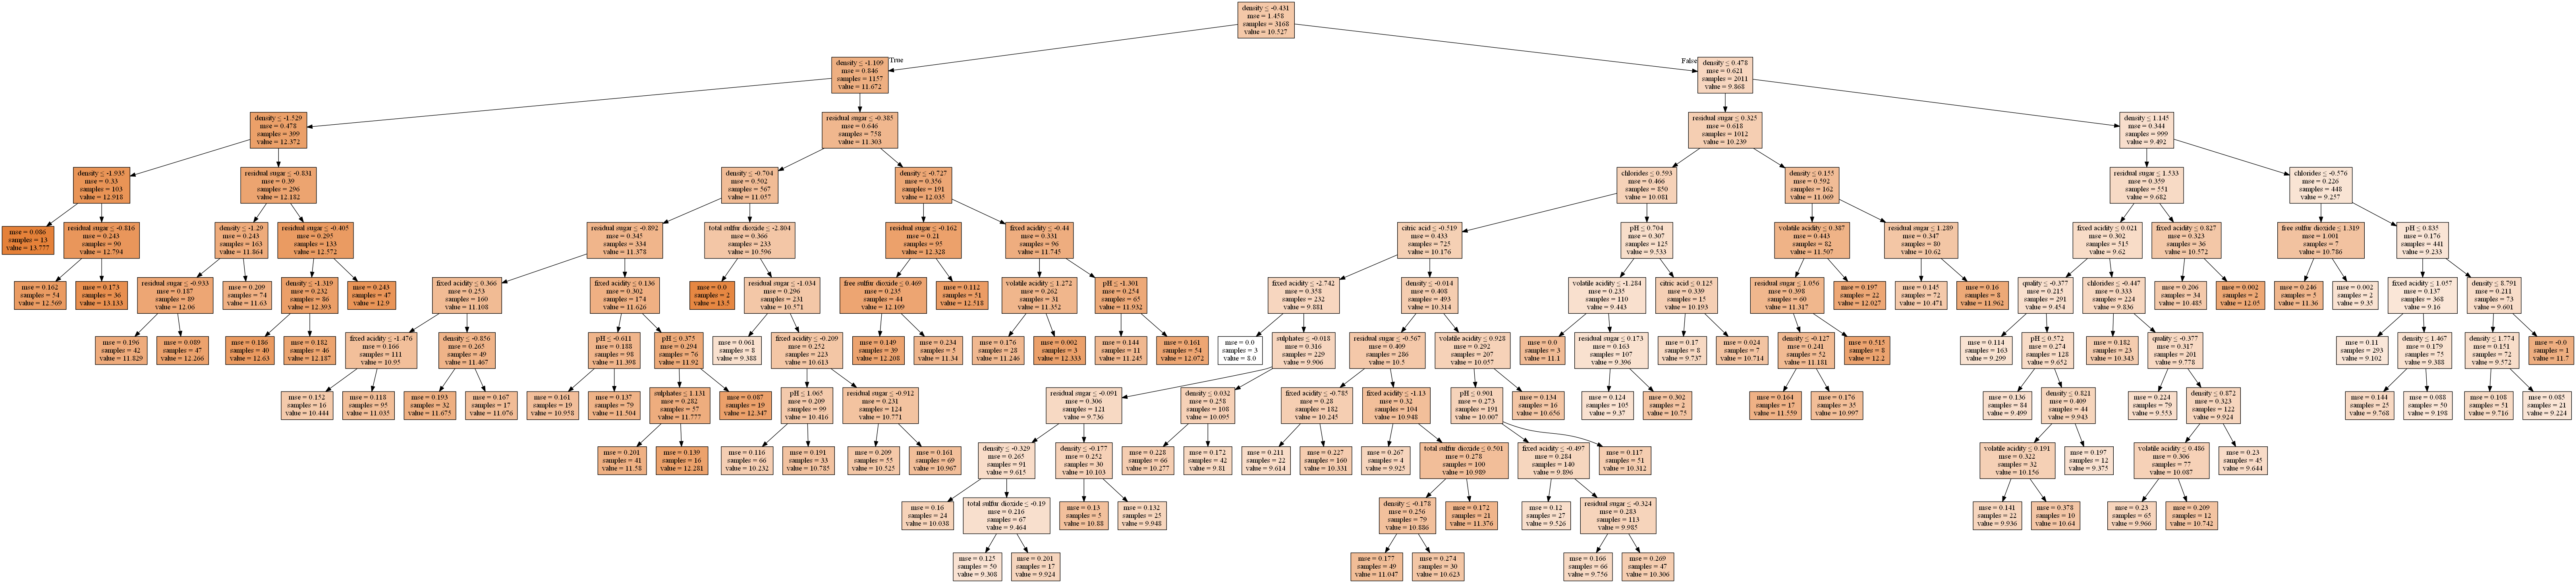

In [35]:
dot_data = tree.export_graphviz(Cart,feature_names = list(data.columns),
                                class_names = [str(i) for i in target.unique()],
                                filled =True,special_characters=True)

graph = pydotplus.graph_from_dot_data(dot_data)


Image(graph.create_png())

## 4. Comparison regression
Predict wine alcohol concentration with Linear Regression. Compare mean absolute errors and rooted mean squared errors. What is the best model?

In [109]:
param_grid = {'alpha':[0,0.1,1,10,100],'solver':['svd','cholesky','sparse_cg','lsqr','sag','saga']}
grid = GridSearchCV(Ridge(),param_grid,refit=True,verbose=1,cv=cv)

grid.fit(X,ytrain)


Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    1.0s finished


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
             error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [0, 0.1, 1, 10, 100],
                         'solver': ['svd', 'cholesky', 'sparse_cg', 'lsqr',
                                    'sag', 'saga']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=1)

In [110]:
print("The best Ridge test score is %s corresponding to hyperparameters %s" %(grid.best_score_,grid.best_params_))

The best Ridge test score is 0.8283362374911171 corresponding to hyperparameters {'alpha': 10, 'solver': 'lsqr'}


In [111]:
ridge = Ridge(alpha = grid.best_params_['alpha'],solver = grid.best_params_['solver'])
ridge.fit(X,ytrain)
pred_ridge = ridge.predict(x)
print('R2_score for Ridge Regression is ',r2_score(ytest,pred_ridge).round(3))
print('RMSE for Ridge Regression is ',np.sqrt(mean_squared_error(ytest,pred_ridge)).round(3))

R2_score for Ridge Regression is  0.876
RMSE for Ridge Regression is  0.424


In [112]:
param_grid = {'alpha':[0,0.1,1,10,100],'solver':['svd','cholesky','sparse_cg','lsqr','sag','saga']}
grid = GridSearchCV(Ridge(),param_grid,refit=True,verbose=2,cv=cv)
poly_X = PolynomialFeatures().fit_transform(X)
poly_x = PolynomialFeatures().fit_transform(x)

grid.fit(poly_X,ytrain)


Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] alpha=0, solver=svd .............................................
[CV] .............................. alpha=0, solver=svd, total=   0.1s
[CV] alpha=0, solver=svd .............................................
[CV] .............................. alpha=0, solver=svd, total=   0.0s
[CV] alpha=0, solver=svd .............................................
[CV] .............................. alpha=0, solver=svd, total=   0.0s
[CV] alpha=0, solver=svd .............................................
[CV] .............................. alpha=0, solver=svd, total=   0.0s
[CV] alpha=0, solver=svd .............................................
[CV] .............................. alpha=0, solver=svd, total=   0.0s
[CV] alpha=0, solver=cholesky ........................................
[CV] ......................... alpha=0, solver=cholesky, total=   0.0s
[CV] alpha=0, solver=cholesky ........................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ......................... alpha=0, solver=cholesky, total=   0.1s
[CV] alpha=0, solver=cholesky ........................................
[CV] ......................... alpha=0, solver=cholesky, total=   0.0s
[CV] alpha=0, solver=cholesky ........................................
[CV] ......................... alpha=0, solver=cholesky, total=   0.0s
[CV] alpha=0, solver=cholesky ........................................
[CV] ......................... alpha=0, solver=cholesky, total=   0.0s
[CV] alpha=0, solver=sparse_cg .......................................
[CV] ........................ alpha=0, solver=sparse_cg, total=   0.0s
[CV] alpha=0, solver=sparse_cg .......................................
[CV] ........................ alpha=0, solver=sparse_cg, total=   0.0s
[CV] alpha=0, solver=sparse_cg .......................................
[CV] ........................ alpha=0, solver=sparse_cg, total=   0.0s
[CV] alpha=0, solver=sparse_cg .......................................
[CV] .

[CV] ........................ alpha=1, solver=sparse_cg, total=   0.0s
[CV] alpha=1, solver=sparse_cg .......................................
[CV] ........................ alpha=1, solver=sparse_cg, total=   0.0s
[CV] alpha=1, solver=sparse_cg .......................................
[CV] ........................ alpha=1, solver=sparse_cg, total=   0.0s
[CV] alpha=1, solver=sparse_cg .......................................
[CV] ........................ alpha=1, solver=sparse_cg, total=   0.0s
[CV] alpha=1, solver=lsqr ............................................
[CV] ............................. alpha=1, solver=lsqr, total=   0.0s
[CV] alpha=1, solver=lsqr ............................................
[CV] ............................. alpha=1, solver=lsqr, total=   0.0s
[CV] alpha=1, solver=lsqr ............................................
[CV] ............................. alpha=1, solver=lsqr, total=   0.0s
[CV] alpha=1, solver=lsqr ............................................
[CV] .

[CV] ...................... alpha=100, solver=sparse_cg, total=   0.0s
[CV] alpha=100, solver=sparse_cg .....................................
[CV] ...................... alpha=100, solver=sparse_cg, total=   0.0s
[CV] alpha=100, solver=sparse_cg .....................................
[CV] ...................... alpha=100, solver=sparse_cg, total=   0.0s
[CV] alpha=100, solver=lsqr ..........................................
[CV] ........................... alpha=100, solver=lsqr, total=   0.0s
[CV] alpha=100, solver=lsqr ..........................................
[CV] ........................... alpha=100, solver=lsqr, total=   0.0s
[CV] alpha=100, solver=lsqr ..........................................
[CV] ........................... alpha=100, solver=lsqr, total=   0.0s
[CV] alpha=100, solver=lsqr ..........................................
[CV] ........................... alpha=100, solver=lsqr, total=   0.0s
[CV] alpha=100, solver=lsqr ..........................................
[CV] .

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:  1.1min finished


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
             error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [0, 0.1, 1, 10, 100],
                         'solver': ['svd', 'cholesky', 'sparse_cg', 'lsqr',
                                    'sag', 'saga']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=2)

In [113]:
print("The best Ridge test score is %s corresponding to hyperparameters %s" %(grid.best_score_,grid.best_params_))

The best Ridge test score is 0.8855336656322474 corresponding to hyperparameters {'alpha': 10, 'solver': 'lsqr'}


In [114]:
ridge_poly = Ridge(alpha = grid.best_params_['alpha'],solver = grid.best_params_['solver'])
ridge_poly.fit(poly_X,ytrain)
pred_ridge_poly = ridge_poly.predict(poly_x)
print('R2_score for Polynomial Ridge Regression is ',r2_score(ytest,pred_ridge_poly).round(3))
print('RMSE for Polynomial Ridge Regression is ',np.sqrt(mean_squared_error(ytest,pred_ridge_poly)).round(3))

R2_score for Polynomial Ridge Regression is  0.9
RMSE for Polynomial Ridge Regression is  0.381


In [117]:
print('R2_score for DecisionTreeRegressor is ',r2_score(ytest,pred_tree).round(3))
print('RMSE for Ridge Regression is ',np.sqrt(mean_squared_error(ytest,pred_tree)).round(3))

print('\nR2_score for Ridge Regression is ',r2_score(ytest,pred_ridge).round(3))
print('RMSE for Ridge Regression is ',np.sqrt(mean_squared_error(ytest,pred_ridge)).round(3))


print('\nR2_score for Polynomial Ridge Regression is ',r2_score(ytest,pred_ridge_poly).round(3))
print('RMSE for Polynomial Ridge Regression is ',np.sqrt(mean_squared_error(ytest,pred_ridge_poly)).round(3))



R2_score for DecisionTreeRegressor is  0.824
RMSE for Ridge Regression is  0.506

R2_score for Ridge Regression is  0.876
RMSE for Ridge Regression is  0.424

R2_score for Polynomial Ridge Regression is  0.9
RMSE for Polynomial Ridge Regression is  0.381
